In [5]:
reset -fs

In [1]:
import re 
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict, Counter
from sklearn.datasets import fetch_covtype # dataset
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, log_loss, classification_report, precision_recall_fscore_support
import xgboost as xgb
from xgboost import XGBClassifier
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('seaborn')
%matplotlib inline

In [2]:
# download the dataset from:
# "http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
cover_type = fetch_covtype() 

In [9]:
# Our data contains 54 features. Explored in depth within the Forest_Cover_Type.ipynb
# set this 581012 x 54 matrix as our feature matrix, X
X = cover_type.data
X.shape

(581012, 54)

In [11]:
"Reduce to {:.2f}% of the orignal dataset.".format(X_res.shape[0]/X.shape[0] * 100)

'Reduce to 3.31% of the orignal dataset.'

In [4]:
X = cover_type.data
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Heavily Imbalanced Dataset

In [8]:
# from the Forest_Cover_Type.ipynb data exploration we discovered there are 7 distinct cover_types
# set these covertypes as our target, y 
y = cover_type.target

print('Original dataset shape:\n {}'.format(Counter(y)))

Original dataset shape:
 Counter({2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})


### Undersample w/ Replacement

In [10]:
ros = RandomUnderSampler(random_state=42, return_indices=True, replacement=True)
X_res, y_res, idx_resampled = ros.fit_sample(X, y)
print('Resampled dataset shape: \n {}'.format(Counter(y_res)))

Resampled dataset shape: 
 Counter({1: 2747, 2: 2747, 3: 2747, 4: 2747, 5: 2747, 6: 2747, 7: 2747})


In [12]:
soil_types = { 
    "2702": "Cathedral family - Rock outcrop complex, extremely stony.",
    "2703": "Vanet - Ratake families complex, very stony.", 
    "2704": "Haploborolis - Rock outcrop complex, rubbly.",
    "2705": "Ratake family - Rock outcrop complex, rubbly.",
    "2706": "Vanet family - Rock outcrop complex complex, rubbly.",
    "2717": "Vanet - Wetmore families - Rock outcrop complex, stony.",
    "3501": "Gothic family.",
    "3502": "Supervisor - Limber families complex.",
    "4201": "Troutville family, very stony.",
    "4703": "Bullwark - Catamount families - Rock outcrop complex, rubbly.",
    "4704": "Bullwark - Catamount families - Rock land complex, rubbly.",
    "4744": "Legault family - Rock land complex, stony.",
    "4758": "Catamount family - Rock land - Bullwark family complex, rubbly.",
    "5101": "Pachic Argiborolis - Aquolis complex.",
    "5151": "not_in_survey", # "unspecified in the USFS Soil and ELU Survey.",
    "6101": "Cryaquolis - Cryoborolis complex.",
    "6102": "Gateview family - Cryaquolis complex.",
    "6731": "Rogert family, very stony.",
    "7101": "Typic Cryaquolis - Borohemists complex.",
    "7102": "Typic Cryaquepts - Typic Cryaquolls complex.",
    "7103": "Typic Cryaquolls - Leighcan family, till substratum complex.",
    "7201": "Leighcan family, till substratum, extremely bouldery.",
    "7202": "Leighcan family, till substratum - Typic Cryaquolls complex.",
    "7700": "Leighcan family, extremely stony.",
    "7701": "Leighcan family, warm, extremely stony.",
    "7702": "Granile - Catamount families complex, very stony.",
    "7709": "Leighcan family, warm - Rock outcrop complex, extremely stony.",
    "7710": "Leighcan family - Rock outcrop complex, extremely stony.",
    "7745": "Como - Legault families complex, extremely stony.",
    "7746": "Como family - Rock land - Legault family complex, extremely stony.",
    "7755": "Leighcan - Catamount families complex, extremely stony.",
    "7756": "Catamount family - Rock outcrop - Leighcan family complex, extremely stony.",
    "7757": "Leighcan - Catamount families - Rock outcrop complex, extremely stony.",
    "7790": "Cryorthents - Rock land complex, extremely stony.",
    "8703": "Cryumbrepts - Rock outcrop - Cryaquepts complex.",
    "8707": "Bross family - Rock land - Cryumbrepts complex, extremely stony.",
    "8708": "Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.",
    "8771": "Leighcan - Moran families - Cryaquolls complex, extremely stony.",
    "8772": "Moran family - Cryorthents - Leighcan family complex, extremely stony.",
    "8776": "Moran family - Cryorthents - Rock land complex, extremely stony."}

# Feature Engineering
# Co-locations

In [13]:
for k, v in soil_types.items():
    fun = re.split(' - |, ', v.lower().replace(".", ""))
    colocations = [i.replace(" ", "_") for i in fun]
    soil_types[k] = " ".join(colocations)

In [14]:
soil_types

{'2702': 'cathedral_family rock_outcrop_complex extremely_stony',
 '2703': 'vanet ratake_families_complex very_stony',
 '2704': 'haploborolis rock_outcrop_complex rubbly',
 '2705': 'ratake_family rock_outcrop_complex rubbly',
 '2706': 'vanet_family rock_outcrop_complex_complex rubbly',
 '2717': 'vanet wetmore_families rock_outcrop_complex stony',
 '3501': 'gothic_family',
 '3502': 'supervisor limber_families_complex',
 '4201': 'troutville_family very_stony',
 '4703': 'bullwark catamount_families rock_outcrop_complex rubbly',
 '4704': 'bullwark catamount_families rock_land_complex rubbly',
 '4744': 'legault_family rock_land_complex stony',
 '4758': 'catamount_family rock_land bullwark_family_complex rubbly',
 '5101': 'pachic_argiborolis aquolis_complex',
 '5151': 'not_in_survey',
 '6101': 'cryaquolis cryoborolis_complex',
 '6102': 'gateview_family cryaquolis_complex',
 '6731': 'rogert_family very_stony',
 '7101': 'typic_cryaquolis borohemists_complex',
 '7102': 'typic_cryaquepts typic_c

# Extract additional information from Map Unit Keys
## First digit:  climatic zone   
## Second digit:  geologic zones
## Third and fourth digits are unique to the mapping unit and have no special meaning

In [15]:
# First digit:  climatic zone   
first_digit = { "1": "lower montane dry",
                "2": "lower montane",          
                "3": "montane dry",            
                "4": "montane",                
                "5": "montane dry and montane",
                "6": "montane and subalpine",
                "7": "subalpine",  
                "8": "alpine" 
              }  

# Second digit:  geologic zones
second_digit = {"1": "alluvium",
                "2": "glacial",
                "3": "shale",
                "4": "sandstone",
                "5": "mixed sedimentary",
                "6": "not_in_survey", #"unspecified in the USFS ELU Survey"
                "7": "igneous and metamorphic",
                "8": "volcanic"
               }

# The third and fourth ELU digits are unique to the mapping unit and 
# have no special meaning to the climatic or geologic zones.

In [16]:
for k, v in first_digit.items():
    first_digit[k] = v.replace(" ", "_")

In [17]:
first_digit

{'1': 'lower_montane_dry',
 '2': 'lower_montane',
 '3': 'montane_dry',
 '4': 'montane',
 '5': 'montane_dry_and_montane',
 '6': 'montane_and_subalpine',
 '7': 'subalpine',
 '8': 'alpine'}

In [18]:
for k, v in second_digit.items():
    second_digit[k] = v.replace(" ", "_")

In [19]:
second_digit

{'1': 'alluvium',
 '2': 'glacial',
 '3': 'shale',
 '4': 'sandstone',
 '5': 'mixed_sedimentary',
 '6': 'not_in_survey',
 '7': 'igneous_and_metamorphic',
 '8': 'volcanic'}

In [20]:
soil_types_extend = defaultdict(str, soil_types)

for k in soil_types_extend.keys():
    climatic = "climatic_zone_" + first_digit.get(k[0])
    geologic = "geologic_zone_" + second_digit.get(k[1])
    soil_types_extend[k] += " " + climatic + " " + geologic

# Add new features to Soil Types

In [21]:
soil_types_extend

defaultdict(str,
            {'2702': 'cathedral_family rock_outcrop_complex extremely_stony climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic',
             '2703': 'vanet ratake_families_complex very_stony climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic',
             '2704': 'haploborolis rock_outcrop_complex rubbly climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic',
             '2705': 'ratake_family rock_outcrop_complex rubbly climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic',
             '2706': 'vanet_family rock_outcrop_complex_complex rubbly climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic',
             '2717': 'vanet wetmore_families rock_outcrop_complex stony climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic',
             '3501': 'gothic_family climatic_zone_montane_dry geologic_zone_mixed_sedimentary',
             '3502': 'supervisor limber_families_complex climatic_zone

# Repeat for Wilderness Areas

In [22]:
# The wilderness areas are
wilderness_areas =   {'Wilderness_Area1': "Rawah Wilderness Area", 
                      'Wilderness_Area2': "Neota Wilderness Area",
                      'Wilderness_Area3': "Comanche Peak Wilderness Area",
                      'Wilderness_Area4': "Cache la Poudre Wilderness Area"}

In [23]:
for k, v in wilderness_areas.items():
    wilderness_areas[k] = v.lower().replace(" ", "_")

In [24]:
wilderness_areas

{'Wilderness_Area1': 'rawah_wilderness_area',
 'Wilderness_Area2': 'neota_wilderness_area',
 'Wilderness_Area3': 'comanche_peak_wilderness_area',
 'Wilderness_Area4': 'cache_la_poudre_wilderness_area'}

In [25]:
soil_cols = list(soil_types_extend.values())
wilderness_cols = list(wilderness_areas.values())

In [27]:
wild_test = pd.DataFrame(X_res[:, 10:14], columns=wilderness_cols).head()
wild_test

,rawah_wilderness_area,neota_wilderness_area,comanche_peak_wilderness_area,cache_la_poudre_wilderness_area
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


In [28]:
pd.Series(wild_test.idxmax(axis=1))

0    comanche_peak_wilderness_area
1    comanche_peak_wilderness_area
2    comanche_peak_wilderness_area
3    comanche_peak_wilderness_area
4    comanche_peak_wilderness_area
dtype: object

In [29]:
soil_test = pd.DataFrame(X_res[:, 14:], columns=soil_cols).head()
soil_test

,cathedral_family rock_outcrop_complex extremely_stony climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic,vanet ratake_families_complex very_stony climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic,haploborolis rock_outcrop_complex rubbly climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic,ratake_family rock_outcrop_complex rubbly climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic,vanet_family rock_outcrop_complex_complex rubbly climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic,vanet wetmore_families rock_outcrop_complex stony climatic_zone_lower_montane geologic_zone_igneous_and_metamorphic,gothic_family climatic_zone_montane_dry geologic_zone_mixed_sedimentary,supervisor limber_families_complex climatic_zone_montane_dry geologic_zone_mixed_sedimentary,troutville_family very_stony climatic_zone_montane geologic_zone_glacial,bullwark catamount_families rock_outcrop_complex rubbly climatic_zone_montane geologic_zone_igneous_and_metamorphic,...,leighcan catamount_families_complex extremely_stony climatic_zone_subalpine geologic_zone_igneous_and_metamorphic,catamount_family rock_outcrop leighcan_family_complex extremely_stony climatic_zone_subalpine geologic_zone_igneous_and_metamorphic,leighcan catamount_families rock_outcrop_complex extremely_stony climatic_zone_subalpine geologic_zone_igneous_and_metamorphic,cryorthents rock_land_complex extremely_stony climatic_zone_subalpine geologic_zone_igneous_and_metamorphic,cryumbrepts rock_outcrop cryaquepts_complex climatic_zone_alpine geologic_zone_igneous_and_metamorphic,bross_family rock_land cryumbrepts_complex extremely_stony climatic_zone_alpine geologic_zone_igneous_and_metamorphic,rock_outcrop cryumbrepts cryorthents_complex extremely_stony climatic_zone_alpine geologic_zone_igneous_and_metamorphic,leighcan moran_families cryaquolls_complex extremely_stony climatic_zone_alpine geologic_zone_igneous_and_metamorphic,moran_family cryorthents leighcan_family_complex extremely_stony climatic_zone_alpine geologic_zone_igneous_and_metamorphic,moran_family cryorthents rock_land_complex extremely_stony climatic_zone_alpine geologic_zone_igneous_and_metamorphic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
wild_test.idxmax(axis=1) + ". " + soil_test.idxmax(axis=1)

0    comanche_peak_wilderness_area. catamount_famil...
1    comanche_peak_wilderness_area. moran_family cr...
2    comanche_peak_wilderness_area. leighcan catamo...
3    comanche_peak_wilderness_area. catamount_famil...
4    comanche_peak_wilderness_area. leighcan_family...
dtype: object

In [31]:
wild_df = pd.DataFrame(X_res[:, 10:14], columns=wilderness_cols)

soil_df = pd.DataFrame(X_res[:, 14:], columns=soil_cols)

X_wild_soil = wild_df.idxmax(axis=1) + " " + soil_df.idxmax(axis=1)
X_wild_soil.head(10)

0    comanche_peak_wilderness_area catamount_family...
1    comanche_peak_wilderness_area moran_family cry...
2    comanche_peak_wilderness_area leighcan catamou...
3    comanche_peak_wilderness_area catamount_family...
4    comanche_peak_wilderness_area leighcan_family ...
5    comanche_peak_wilderness_area catamount_family...
6    neota_wilderness_area catamount_family rock_ou...
7    rawah_wilderness_area como legault_families_co...
8    rawah_wilderness_area leighcan_family till_sub...
9    comanche_peak_wilderness_area catamount_family...
dtype: object

In [32]:
X_wild_soil[0]

'comanche_peak_wilderness_area catamount_family rock_outcrop leighcan_family_complex extremely_stony climatic_zone_subalpine geologic_zone_igneous_and_metamorphic'

# Naive Bayes

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_recall_fscore_support

# Count Vectorizer

In [34]:
# CountVectorizer for entire dataset
min_df = 1 # default making a point to keep all features if min_df=2 then only token removed is 'not_in_survey'
max_df = 0.95 # unless they appear in all docs 
max_features = 100
vectorizer = CountVectorizer(max_features=max_features, max_df=max_df, min_df=min_df)

X_vectorized = vectorizer.fit_transform(X_wild_soil)
X_vectorized.shape, vectorizer.stop_words_

((19229, 75), set())

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_res, test_size=0.2, random_state=42)

In [36]:
clf = MultinomialNB(alpha=1.0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5748829953198128

In [37]:
y_pred = clf.predict(X_test)
y_pred[:5]

array([1, 3, 7, 4, 2], dtype=int32)

In [40]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.50      0.42      0.45       543
          2       0.42      0.56      0.48       554
          3       0.53      0.43      0.47       569
          4       0.66      0.78      0.71       537
          5       0.63      0.49      0.55       550
          6       0.49      0.56      0.52       568
          7       0.88      0.81      0.85       525

avg / total       0.58      0.57      0.57      3846



In [41]:
confusion_matrix(y_test, y_pred)

array([[226, 227,   1,   0,  35,   4,  50],
       [108, 310,   7,   3,  81,  37,   8],
       [  0,   1, 243, 135,   3, 187,   0],
       [  0,   0,  71, 418,   0,  48,   0],
       [ 71, 110,  43,   0, 267,  59,   0],
       [ 15,  24,  95,  80,  34, 320,   0],
       [ 33,  60,   0,   0,   5,   0, 427]])

# No smoothing

In [174]:
clf = MultinomialNB(alpha=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test) # accuracy

/Users/adamszabunio/anaconda/envs/nlp/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.57514300572022881

In [175]:
y_pred = clf.predict(X_test)
y_pred[:5]

array([1, 3, 7, 4, 2], dtype=int32)

In [176]:
f1_score(y_test, y_pred, average='macro')

0.57703767801433958

In [177]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.50      0.42      0.45       543
          2       0.42      0.56      0.48       554
          3       0.53      0.43      0.47       569
          4       0.66      0.78      0.71       537
          5       0.63      0.49      0.55       550
          6       0.49      0.56      0.52       568
          7       0.88      0.81      0.85       525

avg / total       0.58      0.58      0.57      3846



# TF-IDF Vectorizer

In [42]:
# Tfidf on entire dataset (balanced)
min_df = 1 # default making a point to keep all features 
max_df = 0.95 # unless they appear in all docs 
max_features = 100 # not a problem here... soil + wilderness has a max of 70 feats

tfidf_vec = TfidfVectorizer(max_features=max_features, max_df=max_df, min_df=min_df)

X_tfidf = tfidf_vec.fit_transform(X_wild_soil)
X_tfidf.shape, tfidf_vec.stop_words_

((19229, 75), set())

In [43]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tfidf, y_res, test_size=0.2, random_state=42)

In [44]:
clf = MultinomialNB(alpha=0.1)
clf.fit(X_train2, y_train2)
clf.score(X_test2, y_test2)

0.57384295371814875

In [45]:
y_pred2 = clf.predict(X_test2)
y_probs2 = clf.predict_proba(X_test2)
y_pred2[1], y_probs2[1]

(3, array([  4.46240705e-06,   1.83518055e-03,   7.03904301e-01,
          2.38418404e-02,   3.58901009e-02,   2.34522845e-01,
          1.26992217e-06]))

In [46]:
print(classification_report(y_test2, y_pred2))

             precision    recall  f1-score   support

          1       0.50      0.42      0.46       543
          2       0.42      0.55      0.48       554
          3       0.50      0.51      0.50       569
          4       0.74      0.65      0.69       537
          5       0.63      0.48      0.55       550
          6       0.49      0.60      0.54       568
          7       0.88      0.81      0.85       525

avg / total       0.59      0.57      0.58      3846



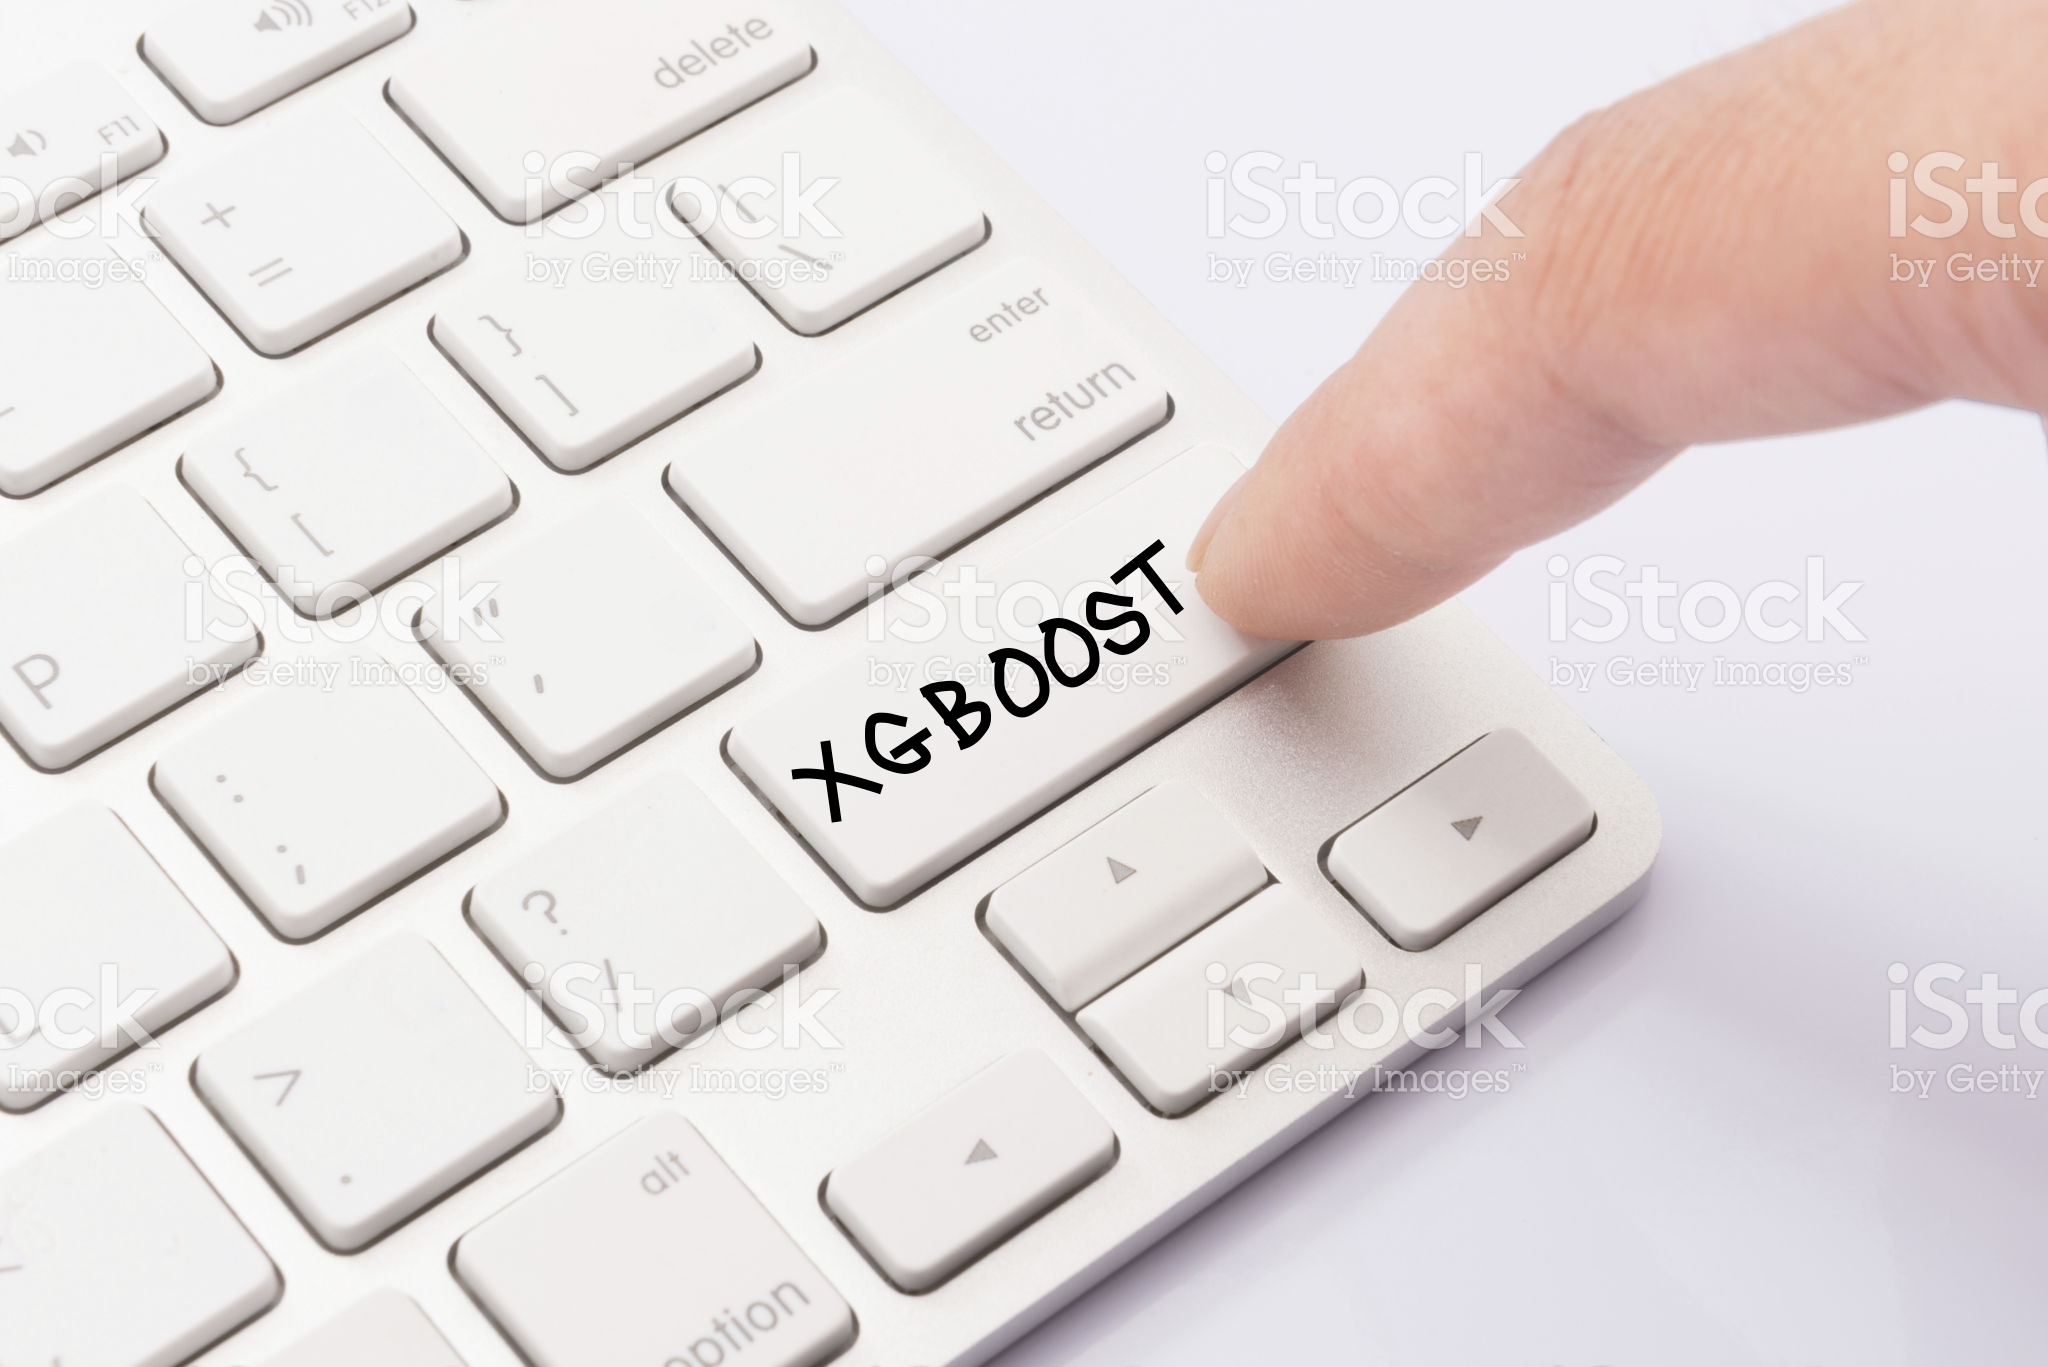

In [4]:
Image(filename='button.jpeg') 

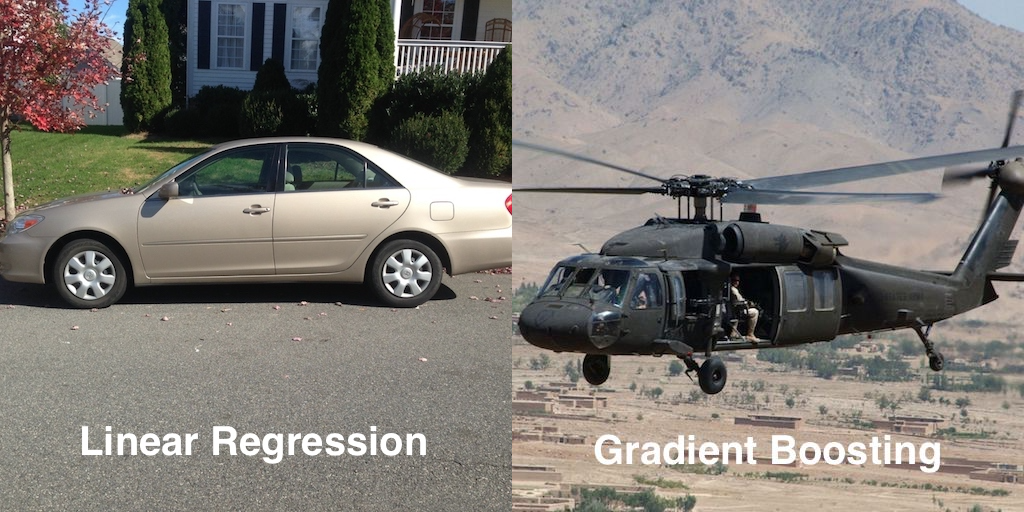

In [265]:
Image("http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2017/01/blog_Gradient-Boosting-Image.png")

In [258]:
print(X_train[0])

  (0, 17)	1
  (0, 34)	1
  (0, 72)	1
  (0, 11)	1
  (0, 70)	1
  (0, 51)	1


In [218]:
X_train_df = pd.DataFrame(X_train.todense(), columns=feat_names)
X_train_df.head()

,aquolis_complex,borohemists_complex,bross_family,bullwark,bullwark_family_complex,cache_la_poudre_wilderness_area,catamount_families,catamount_families_complex,catamount_family,cathedral_family,...,troutville_family,typic_cryaquepts,typic_cryaquolis,typic_cryaquolls,typic_cryaquolls_complex,vanet,vanet_family,very_stony,warm,wetmore_families
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [310]:
n_folds = 10

def modelfit(alg, data, target, test_data, test_target, 
             weights=None, cv_folds=n_folds, early_stop=None, plot=True):
    
    xgb_params = alg.get_xgb_params()
    xgb_params['num_class'] = 7
    metric = xgb_params['eval_metric']
    
    xgtrain = xgb.DMatrix(data, label=target, weight=weights)
    cv_result = xgb.cv(params=xgb_params, 
                          dtrain=xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics=metric,
                          early_stopping_rounds=early_stop, 
                          stratified=True)
        
    #fit alg on data
    alg.set_params(n_estimators=cv_result.shape[0])  
     
    alg.fit(data, target, eval_metric=metric)
    
    test_score = alg.score(test_data, test_target)
    test_preds = alg.predict(test_data)
    test_probs = alg.predict_proba(test_data)  
    
    print("\nHold out test set accuracy score: {:.2f} \n".format(test_score*100))
    print("Classification report: \n")
    print(classification_report(test_target, test_preds))
    
    print("\nBest log loss score for test CV: {}".format(cv_result["test-{}-mean".format(metric)].min()))

    print("\nHold out test set log loss score: {}".format(log_loss(test_target, test_probs)))
    
    if plot:
        rcParams['figure.figsize'] = 8, 8
        cv_result[["train-{}-mean".format(metric), "test-{}-mean".format(metric)]].plot()
        plt.title('{} fold cross val results for training data'.format(cv_folds))
        plt.xlabel('Number of estimators')
        plt.ylabel('{} Score'.format(metric))
        plt.show()
        
        gain_dict = alg.get_booster().get_score(importance_type='gain')
        tots = sum(gain_dict.values())
        feat_score_gain = defaultdict(int)
        feat_keys = np.array(xgb_params["feature_names"])[np.argsort(list(gain_dict.keys()))]
        
        for key, val in zip(feat_keys, gain_dict.values()):
            feat_score_gain[key] += (val/tots)
            
        feat_imp = pd.Series(feat_score_gain).sort_values(ascending=True)[-20:]
        plt.xlabel('Normalized Feature Importance Score')
        feat_imp.plot(kind='barh', title="Average gain of splits which use the feature")
        plt.show()
        
#     else: # plot all features
#         rcParams['figure.figsize'] = 12, 24
#         num_trees = alg.get_params()["n_estimators"]
#         xgb.plot_importance(alg, title='Feature Importance ({} Trees)'.format(num_trees))

Fitting baseline model with 10 fold CV

Hold out test set accuracy score: 59.46 

Classification report: 

             precision    recall  f1-score   support

          0       0.51      0.39      0.44       543
          1       0.43      0.60      0.50       554
          2       0.52      0.51      0.52       569
          3       0.77      0.71      0.74       537
          4       0.61      0.56      0.58       550
          5       0.54      0.60      0.57       568
          6       0.89      0.81      0.85       525

avg / total       0.61      0.59      0.60      3846


Best log loss score for test CV: 0.930385

Hold out test set log loss score: 0.9445802182723388


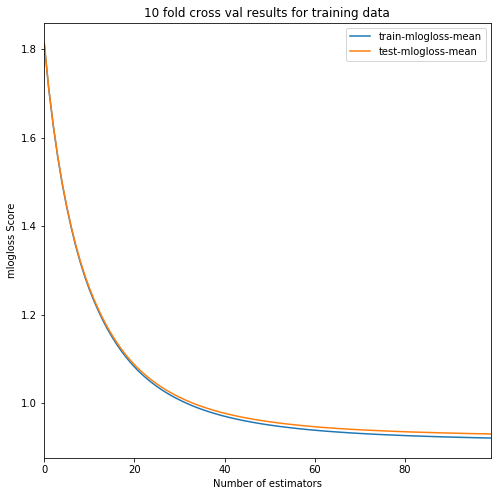

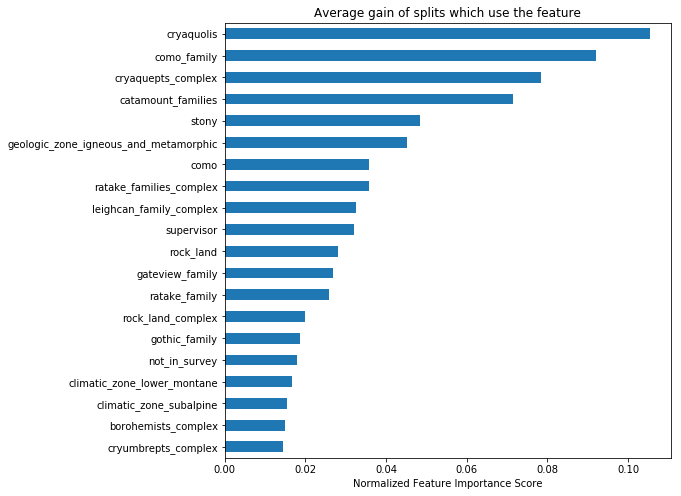


Time to complete fitting baseline model 0:00:34.798496


In [233]:
feat_names = vectorizer.get_feature_names()

start = datetime.now()
print('Fitting baseline model with {} fold CV'.format(n_folds))
xgb_baseline = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax", 
    eval_metric="mlogloss",
    feature_names=feat_names,
    nthread=4,
    seed=42)

# arguments: alg, data, target, test_data, test_target
modelfit(xgb_baseline, X_train, y_train-1, X_test, y_test-1)

end = datetime.now()
print('\nTime to complete fitting baseline model {}'.format(end-start))

# Tf_idf --> XGBoost

In [260]:
print(X_train2[0])

  (0, 51)	0.559307168682
  (0, 70)	0.458806793127
  (0, 11)	0.320399533591
  (0, 72)	0.537955900499
  (0, 34)	0.153154148469
  (0, 17)	0.247311973915


# Baseline 100 trees

Fitting baseline model with 10 fold CV

Hold out test set accuracy score: 59.46 

Classification report: 

             precision    recall  f1-score   support

          0       0.51      0.39      0.44       543
          1       0.43      0.59      0.50       554
          2       0.52      0.51      0.52       569
          3       0.77      0.71      0.74       537
          4       0.61      0.56      0.58       550
          5       0.54      0.60      0.57       568
          6       0.88      0.81      0.85       525

avg / total       0.61      0.59      0.60      3846


Best log loss score for test CV: 0.9257556000000001

Hold out test set log loss score: 0.9416152376456848


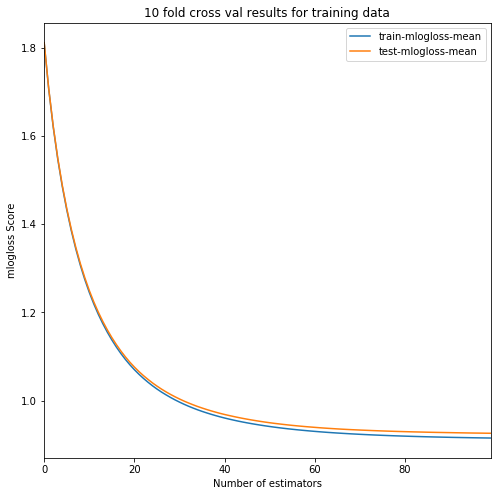

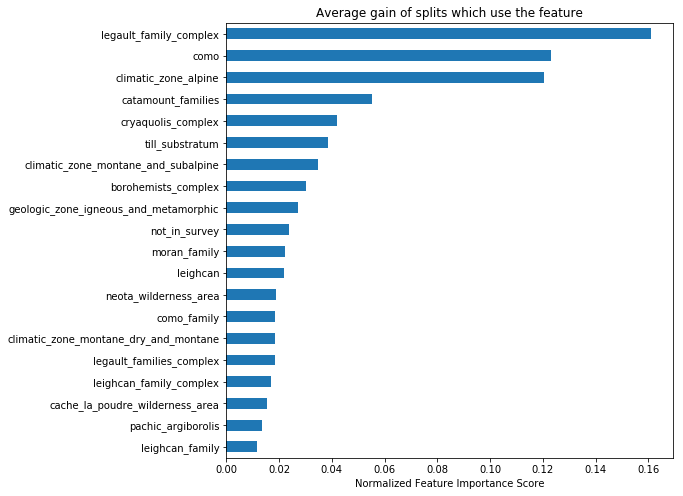


Time to complete fitting baseline model 0:00:51.017677


In [261]:
feat_names_tf_idf = tfidf_vec.get_feature_names()

start = datetime.now()
print('Fitting baseline model with {} fold CV'.format(n_folds))
xgb_baseline = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax", 
    eval_metric="mlogloss",
    feature_names=feat_names_tf_idf,
    nthread=4,
    seed=42)

# arguments: alg, data, target, test_data, test_target
modelfit(xgb_baseline, X_train2, y_train2-1, X_test2, y_test2-1)

end = datetime.now()
print('\nTime to complete fitting baseline model {}'.format(end-start))

# 1000 Estimators (Trees) with Early Stopping 

Fitting baseline model with 10 fold CV

Hold out test set accuracy score: 59.46 

Classification report: 

             precision    recall  f1-score   support

          0       0.51      0.38      0.44       543
          1       0.43      0.59      0.50       554
          2       0.52      0.51      0.52       569
          3       0.77      0.71      0.74       537
          4       0.61      0.57      0.59       550
          5       0.54      0.60      0.57       568
          6       0.88      0.81      0.85       525

avg / total       0.61      0.59      0.60      3846


Best log loss score for test CV: 0.9228357

Hold out test set log loss score: 0.9392372475290398


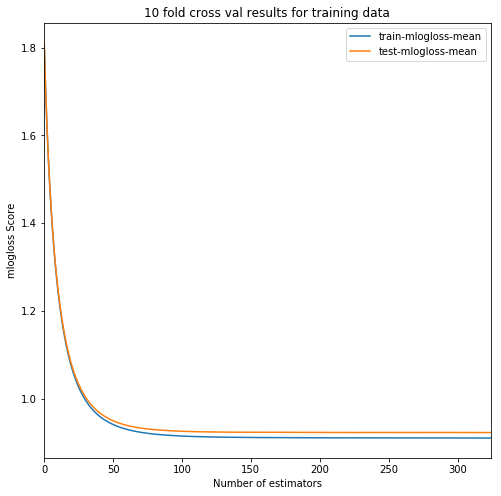

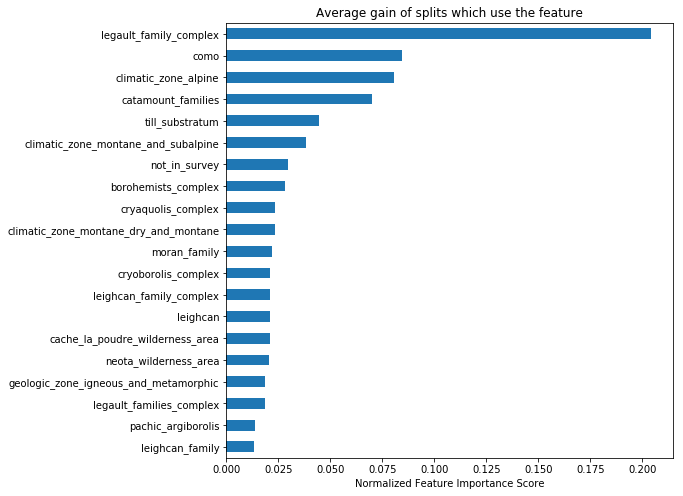


Time to complete fitting baseline model 0:03:35.254247


In [262]:
start = datetime.now()
print('Fitting baseline model with {} fold CV'.format(n_folds))
xgb_baseline = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=1000,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax", 
    eval_metric="mlogloss",
    feature_names=feat_names_tf_idf,
    nthread=4,
    seed=42)

# arguments: alg, data, target, test_data, test_target
modelfit(xgb_baseline, X_train2, y_train2-1, X_test2, y_test2-1, early_stop=100)

end = datetime.now()
print('\nTime to complete fitting baseline model {}'.format(end-start))

In [263]:
# Utility function to report best scores
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=3):
    """
    results: <grid_search>.cv_results_
    n_top: num top results to print 
    """
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [298]:
def tune_Xgboost_lite(X, y, weights=None, rand_iter=10, scoring_method="neg_log_loss", njobs=-1, folds=5):
    """Draw randomly from a distribution of parameters recommended by a kaggle master:
    http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/
    After sampling from random_param_dist (model complexity and model randomness),
    See if regularization helps, if so include Lambda and Alpha parameters and further tune the model.
    Final tuning bumps the estimators and reduces the learning rate. Note that one of the 4 options in 
    the final exhaustive grid search will be a combination of current best lr/est 
    Parameters:
    rand_iter=10, number of times to sample from both random parameter distributions
    scoring_method="neg_log_loss", scoring method, default set to log loss (neg implies maximization)
    njobs=-1, num of cpus to use, default set to all available 
    folds=5, num of folds to use in each CV fit, default is set for 80/20 splits
    """
    
    random_param_dist =   {'n_estimators': [100, 300, 500, 800, 1000],
                           'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
                           'max_depth': [3, 5, 7, 9, 12, 15, 25],
                           'min_child_weight': [1, 3, 5, 7],
                           'gamma': [0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                           'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], 
                           'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
                            }

    tune_est = xgb.XGBClassifier()

    random_search_cv = RandomizedSearchCV(tune_est, random_param_dist, n_iter=rand_iter,\
                                          scoring=scoring_method, n_jobs=njobs, cv=folds)\
                                          .fit(X, y, weights)
    
    print("RandomizedSearchCV top preforming parameter distributions:")
    print("")
    rand_cv_full = random_search_cv.cv_results_
    report(rand_cv_full, n_top=5)

    best_test_mean_rcv_full = rand_cv_full['mean_test_score'].max()
    tuned_params = random_search_cv.best_params_
    
    tune_est2 = xgb.XGBClassifier(**tuned_params)
    random_param_reg = {'reg_lambda': [1/i for i in range(1,101)], 
                        'reg_alpha': [1/i for i in range(1,101)]}

    random_search_reg = RandomizedSearchCV(tune_est2, random_param_reg, n_iter=rand_iter,\
                                           scoring=scoring_method, n_jobs=njobs, cv=folds)\
                                           .fit(X, y, weights)
    
    rand_cv_reg = random_search_reg.cv_results_
    
    best_test_mean_rcv_reg = rand_cv_reg['mean_test_score'].max()
    
    if best_test_mean_rcv_reg > best_test_mean_rcv_full:
        
        print("RandomizedSearchCV top preforming regularization parameters:")
        print("")
        report(rand_cv_reg, n_top=3)
    
        tuned_params['reg_lambda'] = random_search_reg.best_params_['reg_lambda']
        tuned_params['reg_alpha'] = random_search_reg.best_params_['reg_alpha']
        
    else:
        print("Regularization does not increase mean test score")

    tune_est3 = xgb.XGBClassifier(**tuned_params) # instantiate second model w/ best params from random_search_cv
    lr = tuned_params['learning_rate'] # use the best learning rate from random_search_cv for further tuning
    trees = tuned_params['n_estimators'] # set the min_num of trees to be the best so far
    
    # params to tune for final model 
    lr_params = {'learning_rate': np.linspace(start=lr/10, stop=lr, num=2).tolist(),
                 'n_estimators': [trees, 1500]} 

    gs_cv = GridSearchCV(tune_est3, lr_params, n_jobs=njobs, cv=folds, scoring=scoring_method)\
                        .fit(X, y, weights)
        
    print("GridSearchCV top preforming parameter scores for learning rate and n-estimators:")
    print("")    
    report(gs_cv.cv_results_, n_top=2)
    
    # combine parameters from both grid searches 
    for k in tuned_params.keys():
        if k not in ['learning_rate', 'n_estimators']:
            gs_cv.best_params_[k] = tuned_params[k]

    return gs_cv.best_params_, rand_cv_full, rand_cv_reg, gs_cv.cv_results_ 

In [297]:
start = datetime.now()
print('{}: tuning OHE XGBClassifier model'.format(start))

n_iter = 10
best_params, rand_cv, rand_cv_reg, gs_cv_est = tune_Xgboost(X_train, y_train, rand_iter=n_iter)

end = datetime.now()
print('Time to complete Gridsearching w/ {} RandomizedSearchCV iterations {}'.format(n_iter, (end-start)))

2017-10-10 15:52:10.013212: tuning OHE XGBClassifier model
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  9.4min finished


RandomizedSearchCV top preforming parameter distributions:

Model with rank: 1
Mean validation score: -0.924 (std: 0.006)
Parameters: {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 4, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}

Model with rank: 2
Mean validation score: -0.924 (std: 0.006)
Parameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 0.6}

Model with rank: 3
Mean validation score: -0.925 (std: 0.006)
Parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}

Model with rank: 4
Mean validation score: -0.926 (std: 0.005)
Parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 25, 'learning_rate': 0.1, 'gamma': 0.9, 'colsample_bytree': 0.8}

Model with rank: 5
Mean validation score: -0.935 (std: 0.004)
Parameters: {'su

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 18.4min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 21.4min finished


RandomizedSearchCV top preforming regularization parameters:

Model with rank: 1
Mean validation score: -0.924 (std: 0.006)
Parameters: {'reg_lambda': 0.02857142857142857, 'reg_alpha': 0.08333333333333333}

Model with rank: 2
Mean validation score: -0.924 (std: 0.006)
Parameters: {'reg_lambda': 0.034482758620689655, 'reg_alpha': 0.1}

Model with rank: 3
Mean validation score: -0.924 (std: 0.006)
Parameters: {'reg_lambda': 0.07142857142857142, 'reg_alpha': 0.05}

Model with rank: 4
Mean validation score: -0.924 (std: 0.006)
Parameters: {'reg_lambda': 0.017543859649122806, 'reg_alpha': 0.1}

Model with rank: 5
Mean validation score: -0.924 (std: 0.006)
Parameters: {'reg_lambda': 0.016129032258064516, 'reg_alpha': 0.010309278350515464}

GridSearchCV top preforming parameter scores for learning rate and n-estimators:

Model with rank: 1
Mean validation score: 0.594 (std: 0.005)
Parameters: {'learning_rate': 0.05, 'n_estimators': 1000}

Model with rank: 1
Mean validation score: 0.594 (std: 

In [303]:
pd.DataFrame(rand_cv).sort_values("rank_test_score")

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
9,74.384152,6.300767,-0.923804,-0.910559,0.6,0,0.05,15,4,1000,...,-0.924996,-0.910061,-0.920261,-0.911000,-0.915929,-0.912465,11.318595,1.480036,0.006078,0.001243
5,39.850070,3.147394,-0.924225,-0.911741,0.6,0.01,0.1,9,5,500,...,-0.926398,-0.911129,-0.920290,-0.912441,-0.915816,-0.913677,0.407222,0.175741,0.006455,0.001364
4,30.593086,3.102662,-0.925317,-0.913464,0.6,0,0.05,7,7,500,...,-0.926519,-0.912928,-0.921304,-0.914141,-0.917254,-0.915491,0.244572,0.429365,0.006404,0.001447
3,54.723271,0.911247,-0.925590,-0.915141,0.8,0.9,0.1,25,3,500,...,-0.928324,-0.914643,-0.921662,-0.915542,-0.918176,-0.917332,2.435033,0.151036,0.005306,0.001396
7,53.193364,4.345204,-0.935134,-0.926767,0.9,0.9,0.05,6,6,1000,...,-0.936818,-0.926677,-0.932408,-0.927981,-0.928693,-0.929246,0.208415,0.238904,0.004452,0.001770
2,32.140389,1.963865,-0.962691,-0.955162,0.8,1,0.01,5,2,500,...,-0.968331,-0.953917,-0.958813,-0.956027,-0.956031,-0.957614,1.834420,0.373343,0.004736,0.001484
0,8.271055,0.236212,-1.050082,-1.044205,0.8,0.7,0.025,6,6,100,...,-1.055632,-1.043053,-1.047897,-1.045051,-1.044492,-1.046590,0.260269,0.028925,0.003814,0.001486
1,5.131156,0.201610,-1.095060,-1.091893,0.7,0.9,0.025,3,7,100,...,-1.103177,-1.090853,-1.090822,-1.092591,-1.088860,-1.092621,0.097738,0.013048,0.005196,0.000868
6,9.094146,0.278720,-1.162167,-1.156405,0.7,0,0.015,15,5,100,...,-1.166114,-1.155751,-1.159882,-1.156896,-1.157968,-1.157637,0.182124,0.039665,0.003209,0.000798
8,7.528098,0.191846,-1.293534,-1.289521,1,0.3,0.01,6,4,100,...,-1.298826,-1.289213,-1.292502,-1.289358,-1.288560,-1.290762,0.062900,0.024782,0.003315,0.000643


In [299]:
best_params

{'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_weight': 4,
 'n_estimators': 1000,
 'reg_alpha': 0.08333333333333333,
 'reg_lambda': 0.02857142857142857,
 'subsample': 1.0}

Fitting baseline model with 10 fold CV

Hold out test set accuracy score: 59.46 

Classification report: 

             precision    recall  f1-score   support

          0       0.51      0.38      0.44       543
          1       0.43      0.59      0.50       554
          2       0.52      0.51      0.52       569
          3       0.77      0.71      0.74       537
          4       0.61      0.57      0.59       550
          5       0.54      0.60      0.57       568
          6       0.88      0.81      0.85       525

avg / total       0.61      0.59      0.60      3846


Best log loss score for test CV: 0.9235365

Hold out test set log loss score: 0.9398098325475981


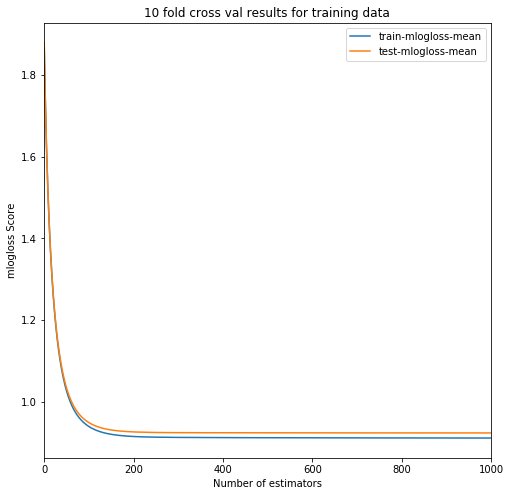

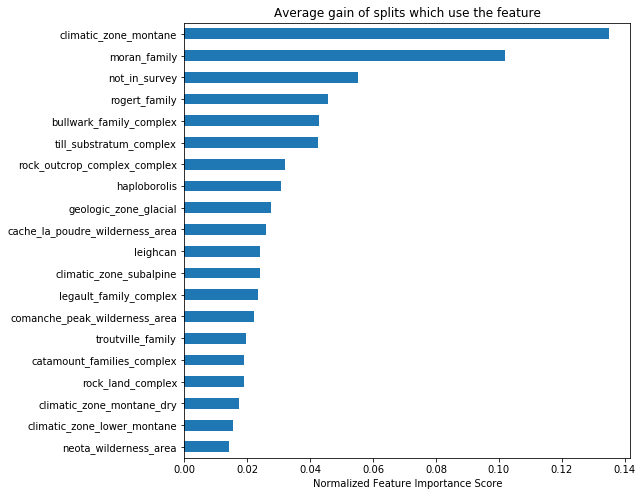


Time to complete fitting baseline model 0:06:54.588066


In [314]:
# feat_names = vectorizer.get_feature_names()
start = datetime.now()
print('Fitting baseline model with {} fold CV'.format(n_folds))
xgb_baseline = XGBClassifier(objective="multi:softmax", 
                                eval_metric="mlogloss",
                                feature_names=feat_names,
                                nthread=4)

xgb_baseline.set_params(**best_params)

# arguments: alg, data, target, test_data, test_target
modelfit(xgb_baseline, X_train, y_train-1, X_test, y_test-1)

end = datetime.now()
print('\nTime to complete fitting baseline model {}'.format(end-start))

In [315]:
start = datetime.now()
print('{}: tuning TF_IDF XGBClassifier model'.format(start))

n_iter = 10
best_params2, rand_cv2, rand_cv_reg2, gs_cv_est2 = tune_Xgboost(X_train2, y_train2, rand_iter=n_iter)

end = datetime.now()
print('Time to complete Gridsearching w/ {} RandomizedSearchCV iterations {}'.format(n_iter, (end-start)))

2017-10-10 17:01:09.146956: tuning TF_IDF XGBClassifier model
RandomizedSearchCV top preforming parameter distributions:

Model with rank: 1
Mean validation score: -0.923 (std: 0.006)
Parameters: {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}

Model with rank: 2
Mean validation score: -0.924 (std: 0.006)
Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.025, 'gamma': 0.01, 'colsample_bytree': 1.0}

Model with rank: 3
Mean validation score: -0.924 (std: 0.006)
Parameters: {'subsample': 0.9, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.025, 'gamma': 0.1, 'colsample_bytree': 0.6}

Model with rank: 4
Mean validation score: -0.925 (std: 0.006)
Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 0.9}

Model wit

In [316]:
pd.DataFrame(rand_cv2).sort_values("rank_test_score")

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
9,88.478955,1.650838,-0.923431,-0.910618,0.6,0.1,0.1,15,5,1000,...,-0.924616,-0.910113,-0.919834,-0.911156,-0.915848,-0.912660,10.768057,0.590214,0.005900,0.001321
4,85.292997,5.278173,-0.923806,-0.911174,1,0.01,0.025,5,7,1000,...,-0.924969,-0.910645,-0.920472,-0.911779,-0.916014,-0.913119,1.466797,0.568057,0.005816,0.001309
3,53.860412,4.063813,-0.924099,-0.911582,0.6,0.1,0.025,6,5,800,...,-0.925560,-0.911073,-0.920674,-0.912168,-0.916585,-0.913548,0.192606,0.310454,0.005713,0.001319
6,9.441209,0.216938,-0.925386,-0.912930,0.9,0.01,0.1,7,2,100,...,-0.927538,-0.912364,-0.921760,-0.913492,-0.917750,-0.914908,0.199420,0.007314,0.005669,0.001268
8,144.720015,4.450732,-0.925463,-0.913731,0.8,0.5,0.01,25,2,1000,...,-0.927387,-0.913186,-0.921802,-0.914393,-0.918497,-0.915668,12.154719,0.109223,0.005246,0.001308
0,55.620911,5.119995,-0.927038,-0.911908,1,0.1,0.1,4,4,1000,...,-0.925368,-0.911242,-0.921966,-0.912676,-0.919796,-0.913782,0.660195,0.390865,0.007692,0.001261
2,94.806189,4.197330,-0.928553,-0.916803,1,0.01,0.01,9,3,800,...,-0.930301,-0.916217,-0.925047,-0.917473,-0.921396,-0.918777,0.397688,0.269782,0.005180,0.001311
7,66.803900,3.367339,-0.928993,-0.917653,0.9,0.05,0.01,6,2,800,...,-0.931622,-0.917013,-0.926015,-0.918291,-0.921835,-0.919737,9.941811,0.317232,0.005004,0.001348
1,30.448849,1.014156,-0.955718,-0.946087,0.8,0.5,0.015,12,6,300,...,-0.958677,-0.945536,-0.952130,-0.946741,-0.950529,-0.947776,0.120162,0.173667,0.004022,0.001116
5,7.859303,0.236342,-1.281137,-1.276074,0.6,0.9,0.01,9,3,100,...,-1.284004,-1.275246,-1.279319,-1.276676,-1.278022,-1.277223,0.035943,0.004245,0.002624,0.000751


In [317]:
pd.DataFrame(gs_cv_est2).sort_values("rank_test_score")

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,151.543021,3.820449,-0.923293,-0.910403,0.1,1500,"{'learning_rate': 0.1, 'n_estimators': 1500, '...",1,-0.933377,-0.908344,...,-0.924636,-0.909826,-0.919620,-0.911028,-0.915601,-0.912426,24.249517,1.146477,0.005936,0.001346
2,118.721096,3.972991,-0.923334,-0.910481,0.1,1000,"{'learning_rate': 0.1, 'n_estimators': 1000}",2,-0.933433,-0.908420,...,-0.924629,-0.909881,-0.919719,-0.911110,-0.915681,-0.912524,1.791167,0.574897,0.005922,0.001355
1,157.198141,9.335185,-0.923980,-0.911638,0.01,1500,"{'learning_rate': 0.01, 'n_estimators': 1500}",3,-0.933547,-0.909591,...,-0.925405,-0.911093,-0.920471,-0.912217,-0.916825,-0.913598,22.353275,0.824731,0.005607,0.001317
0,95.748710,5.318132,-0.925429,-0.913416,0.01,1000,"{'learning_rate': 0.01, 'n_estimators': 1000}",4,-0.934184,-0.911383,...,-0.927069,-0.912869,-0.921873,-0.914041,-0.918614,-0.915373,1.989793,0.464028,0.005262,0.001316


In [318]:
best_params2

{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 5,
 'n_estimators': 1500,
 'reg_alpha': 0.125,
 'reg_lambda': 0.16666666666666666,
 'subsample': 1.0}

Fitting tuned TF_IDF model with 10 fold CV

Hold out test set accuracy score: 59.46 

Classification report: 

             precision    recall  f1-score   support

          0       0.51      0.38      0.44       543
          1       0.43      0.59      0.50       554
          2       0.52      0.51      0.52       569
          3       0.77      0.71      0.74       537
          4       0.61      0.57      0.59       550
          5       0.54      0.60      0.57       568
          6       0.88      0.81      0.85       525

avg / total       0.61      0.59      0.60      3846


Best log loss score for test CV: 0.9227667

Hold out test set log loss score: 0.9388189141298836


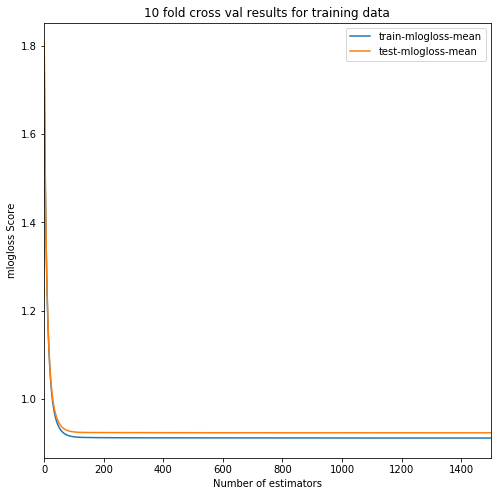

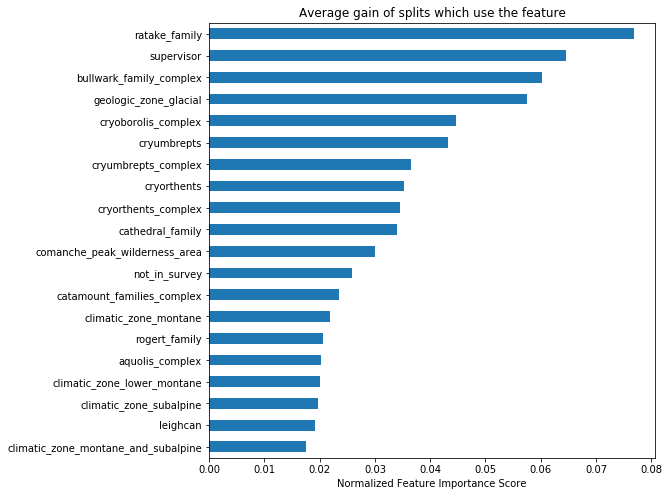


Time to complete fitting baseline model 0:15:51.899631


In [319]:
start = datetime.now()
print('Fitting tuned TF_IDF model with {} fold CV'.format(n_folds))
xgb_baseline2 = XGBClassifier(objective="multi:softmax", 
                                eval_metric="mlogloss",
                                feature_names=feat_names,
                                nthread=4)

xgb_baseline2.set_params(**best_params2)

# arguments: alg, data, target, test_data, test_target
modelfit(xgb_baseline2, X_train2, y_train2-1, X_test2, y_test2-1)

end = datetime.now()
print('\nTime to complete fitting baseline model {}'.format(end-start))

In [320]:
def tune_Xgboost(X, y, weights=None, rand_iter=10):

    random_param_dist =   {'n_estimators': [100, 300, 500, 800, 1000],
                           'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
                           'max_depth': [3, 4, 5, 6, 7, 9, 12, 15, 25],
                           'min_child_weight': [1, 2, 3, 4, 5, 6, 7],
                           'gamma': [0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                           'colsample_bytree': [0.1, 0.6, 0.7, 0.8, 0.9, 1.0], 
                           'subsample': [0.1, 0.6, 0.7, 0.8, 0.9, 1.0]
                                    }

    tune_est = xgb.XGBClassifier()

    random_search_cv = RandomizedSearchCV(tune_est, random_param_dist, n_iter=rand_iter,\
                               scoring="neg_log_loss", n_jobs=4, cv=5).fit(X, y, weights)
    
    print("RandomizedSearchCV top preforming parameter distributions:")
    print("")
    rand_cv_full = random_search_cv.cv_results_
    report(rand_cv_full, n_top=5)

    best_test_mean_so_far = rand_cv_full['mean_test_score'].max()
    tuned_params = random_search_cv.best_params_

    tune_alpha = xgb.XGBClassifier(**tuned_params) 
    alpha_params = {'reg_alpha': [0, 0.01, 0.05, 0.1, 0.5, 1]}
    
    gs_cv_alpha = GridSearchCV(tune_alpha, alpha_params, cv=5, scoring="neg_log_loss", n_jobs=4).\
                    fit(X, y, weights)
    
    alpha_results = gs_cv_alpha.cv_results_
    
    best_test_mean_alpha = alpha_results['mean_test_score'].max()

    if best_test_mean_alpha > best_test_mean_so_far:
        
        print("GridSearchCV alpha top preforming parameters:")
        print("")
        report(alpha_results, n_top=2)
    
        tuned_params["reg_alpha"] = gs_cv_alpha.best_params_["reg_alpha"]
        
    else:
        print("Alpha does not increase mean test score")
    
    
    tune_lambda = xgb.XGBClassifier(**tuned_params)
        
    lambda_params = {'reg_lambda': [0, 0.01, 0.05, 0.1, 0.5, 1]}
    
    gs_cv_lambda = GridSearchCV(tune_lambda, lambda_params, cv=5, scoring="neg_log_loss", n_jobs=4).\
                    fit(X, y, weights)
   
    lambda_results = gs_cv_lambda.cv_results_
    
    best_test_mean_lambda = lambda_results['mean_test_score'].max()
    
    if best_test_mean_lambda > best_test_mean_alpha and best_test_mean_lambda > best_test_mean_so_far:
        
        print("RandomizedSearchCV top preforming Lambda regularization parameters:")
        print("")
        report(lambda_results, n_top=2)
    
        tuned_params['reg_lambda'] = gs_cv_lambda.best_params_['reg_lambda']
        
    else:
        print("Lambda does not increase mean test score")

    tune_est_pump_it_up = xgb.XGBClassifier(**tuned_params) # instantiate second model w/ best params from random_search_cv
    lr = tuned_params['learning_rate'] # use the best learning rate from random_search_cv for further tuning
    trees = tuned_params['n_estimators']
    
    # params to tune for final model 
    lr_params = {'learning_rate': np.linspace(start=lr/10, stop=lr, num=4).tolist(),
                 'n_estimators': [trees, 1750, 2500, 3000]} 

    gs_cv = GridSearchCV(tune_est_pump_it_up, lr_params, cv=5, scoring="neg_log_loss", n_jobs=4).\
            fit(X, y, weights)
        
    print("GridSearchCV top preforming parameter scores for learning rate and n-estimators:")
    print("")    
    report(gs_cv.cv_results_, n_top=3)
    
    # combine parameters from both grid searches 
    for k in tuned_params.keys():
        if k not in ['learning_rate', 'n_estimators']:
            gs_cv.best_params_[k] = tuned_params[k] 

    return gs_cv.best_params_, rand_cv_full, alpha_results, lambda_results, gs_cv.cv_results_ 

In [321]:
start = datetime.now()
print('{}: tuning OHE XGBClassifier model'.format(start))

n_iter = 20
best_params, rand_cv, alpha_gs_cv, lambda_gs_cv, gs_cv_est = tune_Xgboost(X_train, y_train, rand_iter=n_iter)

end = datetime.now()
print('Time to complete Gridsearching w/ {} RandomizedSearchCV iterations {}'.format(n_iter, (end-start)))

2017-10-10 18:21:13.907696: tuning OHE XGBClassifier model
RandomizedSearchCV top preforming parameter distributions:

Model with rank: 1
Mean validation score: -0.924 (std: 0.006)
Parameters: {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}

Model with rank: 2
Mean validation score: -0.926 (std: 0.006)
Parameters: {'subsample': 0.9, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.025, 'gamma': 0.1, 'colsample_bytree': 0.6}

Model with rank: 3
Mean validation score: -0.926 (std: 0.005)
Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 25, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.8}

Model with rank: 4
Mean validation score: -0.926 (std: 0.007)
Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.025, 'gamma': 0.01, 'colsample_bytree': 1.0}

Model with

In [323]:
pd.DataFrame(rand_cv).sort_values("rank_test_score")

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
9,66.962814,2.516193,-0.924442,-0.912159,0.6,0.1,0.1,15,5,1000,...,-0.925696,-0.911838,-0.920991,-0.912540,-0.916575,-0.914096,0.345639,0.168525,0.006054,0.001284
3,41.727815,3.842783,-0.925971,-0.914600,0.6,0.1,0.025,6,5,800,...,-0.927715,-0.914091,-0.921861,-0.915280,-0.917683,-0.916612,0.249859,0.289064,0.006190,0.001412
8,97.959235,4.518937,-0.926198,-0.914990,0.8,0.5,0.01,25,2,1000,...,-0.928716,-0.914514,-0.922356,-0.915670,-0.918791,-0.916928,2.454062,0.248640,0.005361,0.001354
4,60.035486,4.317241,-0.926250,-0.914642,1,0.01,0.025,5,7,1000,...,-0.927514,-0.914052,-0.922244,-0.915461,-0.917417,-0.916696,1.034955,0.236882,0.006500,0.001500
12,25.244014,1.269787,-0.927075,-0.916035,0.9,0.1,0.05,4,5,500,...,-0.928533,-0.915468,-0.923375,-0.916916,-0.917768,-0.918047,0.070051,0.187075,0.006379,0.001493
14,43.326415,3.376144,-0.927152,-0.916583,0.7,0.3,0.025,4,5,1000,...,-0.929463,-0.916008,-0.922994,-0.917345,-0.917962,-0.918712,0.325315,0.161387,0.006421,0.001502
6,6.937457,0.172376,-0.927396,-0.915863,0.9,0.01,0.1,7,2,100,...,-0.930213,-0.915110,-0.924019,-0.916733,-0.919201,-0.918028,0.087543,0.008826,0.005488,0.001447
0,42.140577,4.653631,-0.927532,-0.916732,1,0.1,0.1,4,4,1000,...,-0.929709,-0.916676,-0.921515,-0.917731,-0.919606,-0.919142,0.416312,0.390339,0.006398,0.001719
2,65.652769,3.829604,-0.930633,-0.919747,1,0.01,0.01,9,3,800,...,-0.933118,-0.919132,-0.926855,-0.920485,-0.922589,-0.921906,0.350659,0.187624,0.005606,0.001451
15,5.834464,0.156868,-0.930722,-0.921036,0.8,0.5,0.1,6,6,100,...,-0.933967,-0.920020,-0.927707,-0.922397,-0.921995,-0.923367,0.060741,0.011853,0.005624,0.001686


In [324]:
pd.DataFrame(gs_cv_est).sort_values("rank_test_score")

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
14,217.592601,9.019497,-0.924274,-0.911861,0.1,2500,"{'learning_rate': 0.1, 'n_estimators': 2500, '...",1,-0.934569,-0.909784,...,-0.925627,-0.911532,-0.920798,-0.912291,-0.916431,-0.913783,2.396274,0.533970,0.006026,0.001289
15,228.036908,7.673469,-0.924279,-0.911818,0.1,3000,"{'learning_rate': 0.1, 'n_estimators': 3000}",2,-0.934610,-0.909758,...,-0.925607,-0.911495,-0.920808,-0.912236,-0.916429,-0.913726,34.825739,2.748841,0.006038,0.001278
13,149.857961,6.354364,-0.924326,-0.911956,0.1,1750,"{'learning_rate': 0.1, 'n_estimators': 1750}",3,-0.934653,-0.909880,...,-0.925629,-0.911625,-0.920819,-0.912383,-0.916493,-0.913905,1.995479,0.568943,0.006035,0.001296
12,75.286078,3.373248,-0.924375,-0.912127,0.1,1000,"{'learning_rate': 0.1, 'n_estimators': 1000}",4,-0.934678,-0.910066,...,-0.925631,-0.911791,-0.920959,-0.912549,-0.916555,-0.914087,1.811613,0.842476,0.006011,0.001295
7,230.848774,10.108973,-0.924404,-0.912117,0.04,3000,"{'learning_rate': 0.04, 'n_estimators': 3000}",5,-0.934568,-0.910029,...,-0.925768,-0.911791,-0.920965,-0.912535,-0.916608,-0.914028,1.917554,0.289636,0.005965,0.001289
6,223.742111,8.638724,-0.924424,-0.912181,0.04,2500,"{'learning_rate': 0.04, 'n_estimators': 2500}",6,-0.934573,-0.910095,...,-0.925770,-0.911843,-0.921003,-0.912597,-0.916632,-0.914104,60.876762,0.212860,0.005955,0.001292
11,226.056763,9.263553,-0.924444,-0.911953,0.07,3000,"{'learning_rate': 0.07, 'n_estimators': 3000}",7,-0.934632,-0.909923,...,-0.925770,-0.911600,-0.920882,-0.912374,-0.916497,-0.913816,2.333590,0.521609,0.006023,0.001257
10,191.301983,7.897887,-0.924444,-0.911997,0.07,2500,"{'learning_rate': 0.07, 'n_estimators': 2500}",8,-0.934637,-0.909972,...,-0.925770,-0.911640,-0.920887,-0.912418,-0.916486,-0.913872,0.671905,0.445993,0.006027,0.001259
9,135.004380,5.780907,-0.924496,-0.912092,0.07,1750,"{'learning_rate': 0.07, 'n_estimators': 1750}",9,-0.934731,-0.910058,...,-0.925832,-0.911727,-0.920913,-0.912519,-0.916508,-0.913987,1.151936,0.260215,0.006053,0.001269
5,198.931820,6.878257,-0.924511,-0.912308,0.04,1750,"{'learning_rate': 0.04, 'n_estimators': 1750}",10,-0.934714,-0.910217,...,-0.925825,-0.911972,-0.921059,-0.912723,-0.916741,-0.914244,74.059951,1.926219,0.005970,0.001297


In [325]:
pd.DataFrame(alpha_gs_cv).sort_values("rank_test_score")

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_reg_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,100.381639,3.204946,-0.924425,-0.912201,0.01,{'reg_alpha': 0.01},1,-0.934785,-0.910118,-0.924138,...,-0.925671,-0.911886,-0.920990,-0.912613,-0.916523,-0.914116,26.791383,0.533780,0.006054,0.001287
2,65.375355,2.592029,-0.924437,-0.912242,0.05,{'reg_alpha': 0.05},2,-0.934723,-0.910166,-0.924171,...,-0.925777,-0.911902,-0.920950,-0.912651,-0.916547,-0.914164,0.394921,0.185447,0.006035,0.001288
0,80.132020,2.832058,-0.924442,-0.912159,0,{'reg_alpha': 0},3,-0.934822,-0.910101,-0.924108,...,-0.925696,-0.911838,-0.920991,-0.912540,-0.916575,-0.914096,21.335007,0.203663,0.006054,0.001284
3,63.684362,2.522932,-0.924471,-0.912324,0.1,{'reg_alpha': 0.1},4,-0.934921,-0.910257,-0.924124,...,-0.925915,-0.911979,-0.920847,-0.912754,-0.916532,-0.914267,0.198959,0.155434,0.006125,0.001293
4,57.588640,2.462510,-0.924631,-0.912823,0.5,{'reg_alpha': 0.5},5,-0.934716,-0.910656,-0.924265,...,-0.926642,-0.912338,-0.920699,-0.913422,-0.916814,-0.914715,0.423776,0.108393,0.006041,0.001334
5,46.607738,1.834215,-0.924755,-0.913500,1,{'reg_alpha': 1},6,-0.934159,-0.911368,-0.924862,...,-0.926709,-0.912936,-0.920937,-0.914140,-0.917091,-0.915465,10.164573,0.658552,0.005754,0.001352


In [322]:
best_params

{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 5,
 'n_estimators': 2500,
 'reg_alpha': 0.01,
 'reg_lambda': 0.5,
 'subsample': 1.0}

Fitting baseline model with 10 fold CV

Hold out test set accuracy score: 59.46 

Classification report: 

             precision    recall  f1-score   support

          0       0.51      0.38      0.44       543
          1       0.43      0.59      0.50       554
          2       0.52      0.51      0.52       569
          3       0.77      0.71      0.74       537
          4       0.61      0.57      0.59       550
          5       0.54      0.60      0.57       568
          6       0.88      0.81      0.85       525

avg / total       0.61      0.59      0.60      3846


Best log loss score for test CV: 0.9239984

Hold out test set log loss score: 0.9399037505901994


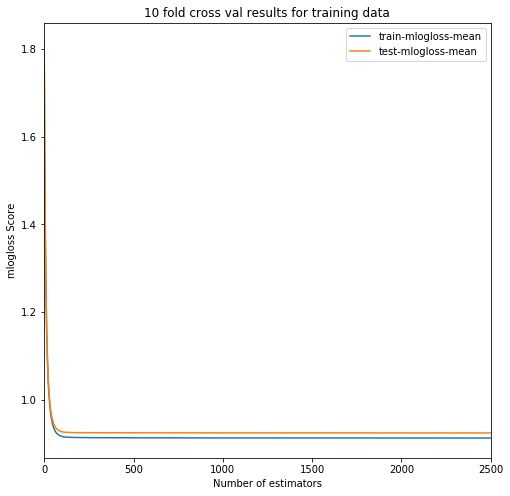

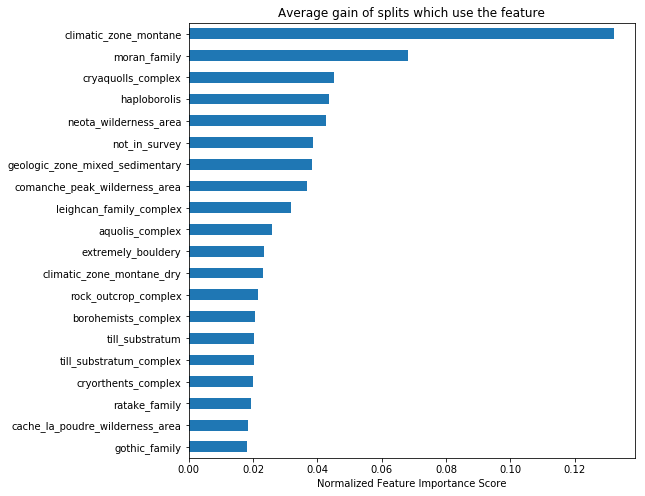


Time to complete fitting baseline model 0:18:44.570420


In [326]:
# feat_names = vectorizer.get_feature_names()
start = datetime.now()
print('Fitting baseline model with {} fold CV'.format(n_folds))
xgb_baseline = XGBClassifier(objective="multi:softmax", 
                                eval_metric="mlogloss",
                                feature_names=feat_names,
                                nthread=4)

xgb_baseline.set_params(**best_params)

# arguments: alg, data, target, test_data, test_target
modelfit(xgb_baseline, X_train, y_train-1, X_test, y_test-1)

end = datetime.now()
print('\nTime to complete fitting baseline model {}'.format(end-start))

In [ ]:
xgb_baseline_es = XGBClassifier( #_es --> early stopping
    max_depth=5,
    learning_rate=0.1,
    n_estimators=1000,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax", 
    eval_metric="logloss", 
    num_classes=7,
    nthread=4,
    seed=42)

xgb_params = xgb_baseline_es.get_xgb_params()
xgtrain = xgb.DMatrix(X.values, label=y.values, weight=weights.values)
cv_result = xgb.cv(params=xgb_params,
                  dtrain=xgtrain,
                  num_boost_round=xgb_baseline_es.get_params()['n_estimators'],
                  nfold=10,
                  metrics='rmse',
                  early_stopping_rounds=50)

In [85]:
xgb_clf = XGBClassifier()

In [99]:
xgb_clf.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>

In [ ]:
param_grid = {"n_estimators": [50, 150],#np.arange(50, 400, 50),
              "max_depth": [4, 5], #np.arange(1, 11, 2), 
              "learning_rate": [0.05, 0.01]#[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
             }
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(xgb_clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=5)
results = grid_search.fit(X_tfidf, y_res)

In [169]:
pd.DataFrame(results.grid_scores_)

,parameters,mean_validation_score,cv_validation_scores
0,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.588746,"[0.587272727273, 0.583376623377, 0.59276606817..."
1,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.593271,"[0.592467532468, 0.586233766234, 0.59562841530..."
2,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.590930,"[0.587792207792, 0.586233766234, 0.59432734842..."
3,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.593323,"[0.592467532468, 0.586233766234, 0.59588862867..."
4,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.582142,"[0.576883116883, 0.575324675325, 0.58417902680..."
5,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.587134,"[0.585714285714, 0.581558441558, 0.59198542805..."
6,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.587966,"[0.584935064935, 0.582597402597, 0.59276606817..."
7,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.590202,"[0.587792207792, 0.584155844156, 0.59276606817..."


In [94]:
print("Best: %f%% using %s" % (results.best_score_, results.best_params_))

Best: -0.935569% using {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}


In [97]:
param_grid = {"n_estimators": [50, 150],#np.arange(50, 400, 50),
              "max_depth": [4, 5], #np.arange(1, 11, 2), 
              "learning_rate": [0.05, 0.01]#[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
             }
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(xgb_clf, param_grid, scoring="accuracy", n_jobs=-1, cv=5)
results = grid_search.fit(X_tfidf, y_res)

In [98]:
print("Best: %f%% using %s" % (results.best_score_ *100, results.best_params_))

Best: 59.332259% using {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}


In [67]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_tfidf, y_res, test_size=0.2, random_state=42)

In [77]:
print(X_train3[0])

  (0, 51)	0.559307168682
  (0, 70)	0.458806793127
  (0, 11)	0.320399533591
  (0, 72)	0.537955900499
  (0, 34)	0.153154148469
  (0, 17)	0.247311973915


In [79]:
xgb_clf.fit(X_train3, y_train3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [82]:
xgb_clf.classes_

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [83]:
xgb_clf.predict_proba(X_test3)[:1]

array([[ 0.49579182,  0.28611025,  0.00252211,  0.00071815,  0.04380472,
         0.10483235,  0.06622061]], dtype=float32)

In [84]:
y_pred3[:1]

array([1], dtype=int32)

In [80]:
xgb_clf.score(X_test3, y_test3)

0.59516380655226209

In [81]:
y_pred3 = xgb_clf.predict(X_test3)
print(classification_report(y_test3, y_pred3))

             precision    recall  f1-score   support

          1       0.51      0.40      0.45       543
          2       0.43      0.59      0.50       554
          3       0.52      0.51      0.52       569
          4       0.77      0.71      0.74       537
          5       0.61      0.56      0.58       550
          6       0.54      0.60      0.57       568
          7       0.89      0.81      0.85       525

avg / total       0.61      0.60      0.60      3846



In [100]:
xgb_clf2 = XGBClassifier(**{'n_estimators': 350, 'learning_rate': 0.3, 'max_depth': 9})

In [101]:
xgb_clf2.fit(X_test3, y_test3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [102]:
xgb_clf2.score(X_test, y_test)

0.32085283411336452

In [103]:
y_pred_3 = xgb_clf2.predict(X_test3)

In [104]:
print(classification_report(y_test3, y_pred_3))

             precision    recall  f1-score   support

          1       0.49      0.45      0.47       543
          2       0.47      0.50      0.49       554
          3       0.59      0.40      0.48       569
          4       0.68      0.83      0.75       537
          5       0.58      0.62      0.60       550
          6       0.54      0.60      0.57       568
          7       0.89      0.81      0.85       525

avg / total       0.60      0.60      0.60      3846



In [35]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=13, max_leaf_nodes=7,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [36]:
grid.best_params_

{'max_depth': 6, 'max_features': 13, 'max_leaf_nodes': 7, 'n_estimators': 100}

In [37]:
grid.best_score_

0.67040599720793248